## Gere lets try to get some data from the alfven modes and train a few autoencoders on them to see if they capture any structure in the latent layer

In [1]:
using AlfvenDetectors
using PyPlot
using Flux
using CuArrays

What we are doing is unsupervised training on columns of the magnitude squared coherence time histograms. 

### Collect the data

Use shot #10370 and #11960 and several coil couples. Select only some timeslices, normalize data

In [2]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/original_data/"

"/home/vit/vyzkum/alfven/cdb_data/original_data/"

In [3]:
function get_msc_array(datapath, shot, coil, timelim = [1.0, 1.25])
    _data = AlfvenDetectors.BaseAlfvenData(joinpath(datapath,"$(shot).h5"), [coil])
    tinds = timelim[1] .<= _data.t .<= timelim[2]
    return _data.msc[coil][:,tinds], _data.t[tinds], _data.f 
end

get_msc_array (generic function with 2 methods)

In [4]:
msc, t, f = get_msc_array(datapath, 11096, 20)

(Float32[0.989127 0.989611 … 0.908824 0.920963; 0.976508 0.977404 … 0.875875 0.849385; … ; 0.0991339 0.0335356 … 0.0584963 0.0771319; 0.0437077 0.143527 … 0.192278 0.0363167], Float32[1.00244, 1.00525, 1.00806, 1.01087, 1.01369, 1.0165, 1.01931, 1.02213, 1.02494, 1.02775  …  1.22462, 1.22744, 1.23025, 1.23306, 1.23588, 1.23869, 1.2415, 1.24431, 1.24713, 1.24994], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

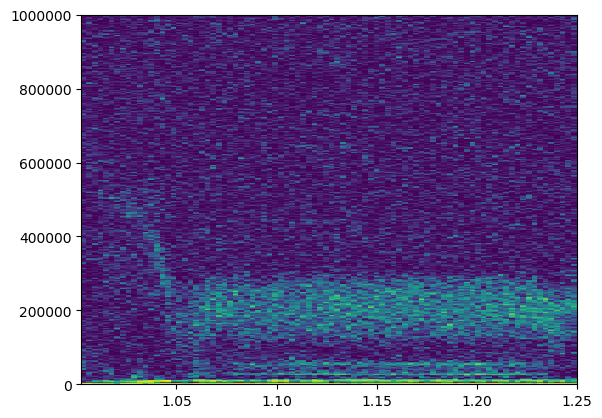

PyObject <matplotlib.collections.QuadMesh object at 0x7efd0c16a7f0>

In [5]:
pcolormesh(t,f,msc)

In [6]:
function collect_msc(datapath, shot, coils)
    datalist = map(x-> get_msc_array(datapath, shot, x), coils)
    return hcat([x[1] for x in datalist]...), datalist[1][3]
end

collect_msc (generic function with 1 method)

In [7]:
shots_coils = [
#    [10370, [12, 15, 17, 20]],
    [10370, [12, 20]],
#    [11096, [11, 8, 17, 20]]
    [11096, [11, 8, 20]]
]
datalist = map(x->collect_msc(datapath, x[1], x[2]), shots_coils)
data, f = hcat([x[1] for x in datalist]...), datalist[1][2]

(Float32[0.918668 0.881605 … 0.908824 0.920963; 0.914609 0.879044 … 0.875875 0.849385; … ; 0.00910574 0.328996 … 0.0584963 0.0771319; 0.0011798 0.310406 … 0.192278 0.0363167], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

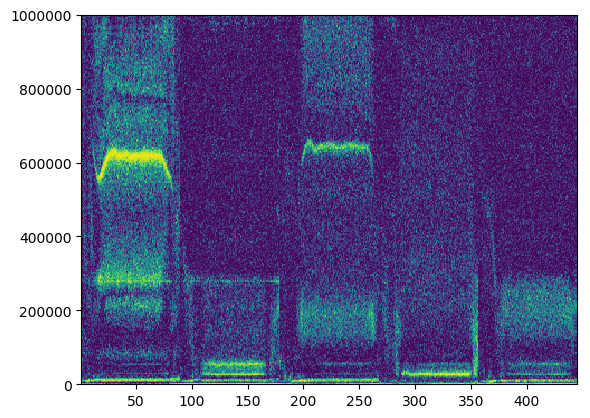

PyObject <matplotlib.collections.QuadMesh object at 0x7efcbefd72b0>

In [8]:
pcolormesh(1:size(data,2), f, data)

### Now that we have the data, construct a (V)AE

In [29]:
M,N = size(data)
# fortunately data is already normalized in the interval (0,1)
zdim = 2
# convert to CuArrays
data = data |> gpu
model = AlfvenDetectors.AE([M, 10, zdim], [zdim, 10, M]) |> gpu

AlfvenDetectors.AE{Chain{Tuple{Dense{typeof(relu),TrackedArray{…,CuArray{Float32,2}},TrackedArray{…,CuArray{Float32,1}}},Dense{typeof(identity),TrackedArray{…,CuArray{Float32,2}},TrackedArray{…,CuArray{Float32,1}}}}},Chain{Tuple{Dense{typeof(relu),TrackedArray{…,CuArray{Float32,2}},TrackedArray{…,CuArray{Float32,1}}},Dense{typeof(identity),TrackedArray{…,CuArray{Float32,2}},TrackedArray{…,CuArray{Float32,1}}}}}}(Chain(Dense(513, 10, NNlib.relu), Dense(10, 2)), Chain(Dense(2, 10, NNlib.relu), Dense(10, 513)))

In [30]:
model(data)

Tracked 513×445 CuArray{Float32,2}:
  0.00472143    0.00658468    0.00253136   …   0.00271068    0.00838734 
  0.00503009    0.00637724    0.00724666       0.00820731    0.0153851  
  0.00905411    0.0125798     0.00133446       0.0022947     0.0182197  
  0.000947893   0.0018329    -0.000268283     -3.29408e-5    0.000429164
 -0.000819896  -0.00256273   -5.02452e-5       3.1409e-5     0.00158821 
 -0.00229039   -0.00189761    0.00102009   …   1.99378e-5   -0.0101418  
 -0.00357147   -0.00404295    0.00025486      -0.000580229  -0.0112104  
  0.00478124    0.0052303     0.00349912       0.00468095    0.0153247  
  0.00422005    0.0043284     0.00897575       0.01015       0.0175516  
 -0.00433251   -0.00735921    0.00127945       0.00172976   -0.00129074 
  0.00578499    0.00835628    0.000493649  …   0.000789783   0.0092283  
 -0.00463356   -0.00583605   -0.0125229       -0.0133257    -0.0165383  
  0.00566695    0.0074726     0.0143382        0.0157213     0.0203638  
  ⋮            

In [59]:
?AlfvenDetectors.AE

```
AE{encoder, sampler, decoder}
```

Flux-like structure for the basic autoencoder.

---

```
AE(esize, dsize; [activation, layer])
```

Initialize an autoencoder with given encoder size and decoder size.

```
esize = vector of ints specifying the width anf number of layers of the encoder
dsize = size of decoder
activation [Flux.relu] = arbitrary activation function
layer [Flux.Dense] = layer type
```
